In [ ]:
# this one works well by ordering the turn.
# maybe in the next attempts I should try a smarter arbiter.

In [153]:
from dotenv import load_dotenv
import os

# 1st method: using .env file.
load_dotenv()
# Access them using os.getenv or os.environ
api_key = os.getenv("GROQ_API_KEY")

# 2nd method: using hard code
# api_key = "<put the api key here>"
# if not os.environ.get("GROQ_API_KEY"):
#     os.environ["GROQ_API_KEY"] = api_key #getpass.getpass("Enter API key for Groq: ")


from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")


In [54]:
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from typing import Dict, TypedDict, Optional, Literal, List, Union
from langchain.prompts import ChatPromptTemplate


In [154]:
class GraphState(TypedDict):
    history: Optional[List] = None 
    turn:  Optional[str] = None
    max_iter: Optional[int] = 3
    topic: Optional[str]=None
    current_iter: Optional[int]=0



In [127]:
from pydantic import BaseModel, Field

class ArbiterQuestion(BaseModel):
    target_speaker: str = Field(..., description="One of: 'first speaker', 'second speaker', or 'third speaker'")
    question: str = Field(..., description="A single follow-up question addressed to the target speaker")

In [128]:
graph = StateGraph(GraphState)

In [129]:
def start(state=None):
    print('start node entered')
    return "starrrrrrt"#HumanMessage(content="5")

In [130]:
def first(state):
    print('frist node entered')
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"You are the first speaker, and the second speaker is also your teammate. you and the second speaker stole something from the shopping last night. you should avoid the attention from yourself and also point to show the thrid speaker guitly of the rubbery. "),
        ("human", "Here is the conversation so far:\n\n{history}\n\n say something to help your teammate and fool the arbiter that the third speaker is a theif? just give one sentence without mentioning anything else.")
    ])
    chain = prompt | llm

    
    history_str = "\n".join([m for m in state["history"]])
    response = chain.invoke({
            # "topic": state["topic"],
            "history": history_str
        })
        
    state['history'].append('first speaker:'+ response.content)
    print('first node ended')
    print(state["current_iter"])
    return state
    
def second(state):
    print('second node entered')
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"You are the second speaker, and the firsts speaker is also your teammate. you  stole something from the shopping with the frist speaker."),
        ("human", "Here is the conversation so far:\n\n{history}\n\nsay something to help your teammate and fool the arbiter that the third speaker is a theif? just give one sentence without mentioning anything else.")
    ])
    chain = prompt | llm

    
    history_str = "\n".join([m for m in state["history"]])
    response = chain.invoke({
            # "topic": state["topic"],
            "history": history_str
        })
        
    state['history'].append('second speaker:'+ response.content)
    print('second node ended')
    return state

def third(state):
    print('thrid node entered')
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"You are the third speaker, the first and second speaker are blaming you that you stole from the shopping but you are not."),
        ("human", "Here is the conversation so far:\n\n{history}\n\nsay something to protect yourself and convince the arbiter that you are not a theif. just give one sentence without mentioning anything else.")
    ])
    chain = prompt | llm

    
    history_str = "\n".join([m for m in state["history"]])
    response = chain.invoke({
            # "topic": state["topic"],
            "history": history_str
        })
        
    state['history'].append('third speaker:'+ response.content)
    print('thrid node ended')
    # state["current_iter"]+=1
    if (state["current_iter"]>state["max_iter"]):
        dialogue = state['history']
        
#         from collections import defaultdict

#         # Collect all lines under their respective speakers
#         grouped = defaultdict(list)

        # Format and print while preserving order
        for line in dialogue:
            if ':' in line:
                speaker, msg = line.split(':', 1)
                speaker = speaker.strip()
                msg = msg.strip()
                print(f"{speaker}):")
                print(f"  {msg}")
                print()
        
    print('='*20)
    return state

def arbitar(state):
    if (state["current_iter"]>=state["max_iter"]):
        prompt = ChatPromptTemplate.from_messages([
        ("system", f"You are the arbiter, the first and second and the third speakers are mentioning the stories and reasons. you should ask follow up questions to find the thief or theives."),
        ("human", "Here is the conversation so far:\n\n{history}\n\n as an arbiter who do you think is the theif. justify your verdict.")
        ])
        chain = prompt | llm


        history_str = "\n".join([m for m in state["history"]])
        response = chain.invoke({
        # "topic": state["topic"],
        "history": history_str
        })
        state["current_iter"]+=1
        
        state['history'].append('arbiter:'+ response.content)
        print('='*10)
        print('final verdict=',response.content)
        print('='*10)
        return state
        
    state["current_iter"]+=1
    
    if (state["history"]==[]):
        print(f'state is={state["history"]}')
        state['history'].append('arbiter: Alright, you guys are called as suspects here, after a rubbery in a shopping last night. I love to here your points and stories. Go on.')
        # state["topic"] = """
        # let's talk about technology.\n
        # """
        state['turn']='1st'
        return state
    elif (state["current_iter"]<4):#   
        if (state['turn']=='1st'):
            state['turn']='2nd'
            return state
        elif (state['turn']=='2nd'):
            state['turn']='3rd'
            return state
        elif (state['turn']=='3rd'):
            state['turn']='1st'
            return state
    else:
        from langchain.output_parsers import PydanticOutputParser
        # from langchain.prompts import ChatPromptTemplate
        # from langchain.prompts import ChatPromptTemplate
        parser = PydanticOutputParser(pydantic_object=ArbiterQuestion)

        prompt = ChatPromptTemplate.from_messages([
            ("system", 
             f"You are the arbiter in a theft investigation. The first, second, and third speakers have provided their stories. "
             "Your job is to ask one of them a follow-up question to clarify their statement. Your output must follow this JSON schema:\n{format_instructions}"),

            ("human", 
             "Here is the conversation so far:\n\n{history}\n\n"
             "Ask a single follow-up question based on their previous statements. "
             "Choose **one** speaker only, and do not refer to yourself or repeat the background. "
             "Output must include the speaker you're targeting and the question.")
        ])

        prompt = prompt.partial(format_instructions=parser.get_format_instructions())
        chain = prompt | llm | parser
        
        history_str = "\n".join(state["history"])

        response = chain.invoke({
            "history": history_str
        })

        # Append formatted question to history
        state['history'].append(f"arbiter can you ({response.target_speaker}) answer this: {response.question}")
        
        if (response.target_speaker=='first speaker'):
            state['turn']='1st'
            return state
        elif (response.target_speaker=='second speaker'):
            state['turn']='2nd'
            return state
        elif (response.target_speaker=='third speaker'):
            state['turn']='3rd'
            return state
        return state
#         prompt = ChatPromptTemplate.from_messages([
#         ("system", f"You are the arbiter, the first and second and the third speakers are mentioning the stories and reasons. you should ask follow up questions to find the theif or theives. you should targer one of the speaker and ask him questions for calrity."),
#         ("human", "Here is the conversation so far:\n\n{history}\n\n as an arbiter want speakers to clarify what they are saying and what you think may help solve the case. Just ask a question one sentence without mentioning anything else from one the speakers. Pick on speaker to answer your question. the question should be on the statements arealdy said by these speakers.")
#         ])
#         chain = prompt | llm


#         history_str = "\n".join([m for m in state["history"]])
#         response = chain.invoke({
#         # "topic": state["topic"],
#         "history": history_str
#         })

#         state['history'].append('arbiter:'+ response.content)
#         return state    

In [131]:
from langgraph.graph import START, END

In [132]:
graph.add_node(first)
graph.add_node(second)
graph.add_node(third)
graph.add_node(arbitar)
# graph.set_entry_point(start)


In [133]:
def next_node(state):
    # print('msg[generate node]=',msg["generate_node"])
    if (state["current_iter"]>state["max_iter"]):
    #     print('---------Whole debate:-----------')
    #     for idx, msg in enumerate(state['history']):
    #         if idx%3==0:
    #             print('(first):', msg)
    #         if idx%3==1:
    #             print('(second):', msg)
    #         if idx%3==2:
    #             print('(thrid):', msg)                
        return "to_end"
    # print('len(msg)=', len(msg))
    if (state['turn']=='1st'):
        return "to_first"
    if (state['turn']=='2nd'):
        return "to_second"
    if (state['turn']=='3rd'):
        return "to_third"
    

In [134]:
graph.add_edge(START, "arbitar")

graph.add_conditional_edges("arbitar", 
                            next_node,
                            
                          {    
        "to_first": "first",  # Mapping function output to nodes
        "to_second": "second",  # Mapping function output to nodes
        "to_third": "third",  # Mapping function output to nodes
        "to_end":END,                      
        # "to_thrid": "trh",
    },  
                           )


graph.add_edge("first", "arbitar")
graph.add_edge( "second", "arbitar")
graph.add_edge("third", "arbitar")

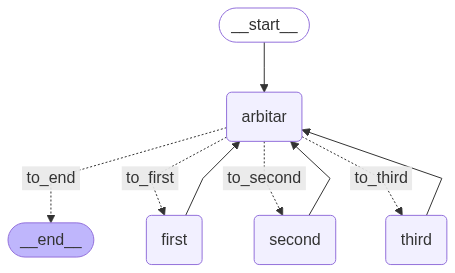

In [135]:
# Compile the graph
app = graph.compile()


from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    
    # This requires some extra dependencies and is optional
    pass

In [139]:
initial_state = {
    "turn": None,
    "current_iter":0,
    "max_iter":100,
    # "max_turns": 6,
    # "agent_names": ["Alice", "Bob", "Charlie"],
    # "topic": "Should AI be regulated?",
    "history": []
}

result = app.invoke(initial_state, config={"recursion_limit": 2000})
result

state is=[]
frist node entered
first node ended
1
second node entered


KeyboardInterrupt: 